# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

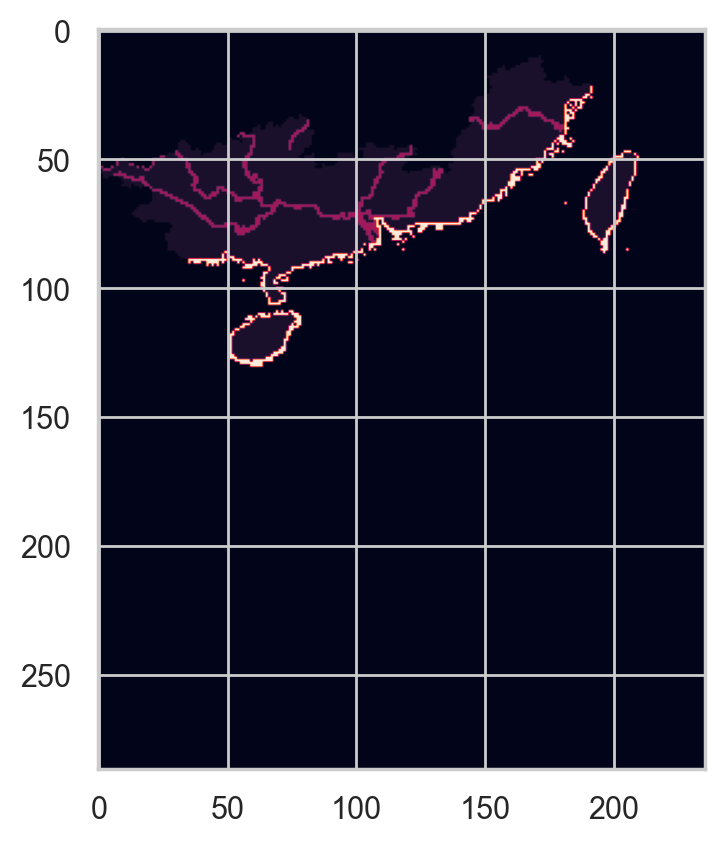

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [3]:
# 从这个路径加载模型
from src.core import Model
from src.api import Env

model = Model(parameters=cfg, nature_class=Env)
model.params.save_plots = False
model.nature.setup()

农民可以停留的可耕种土地有3074，分布如下图：


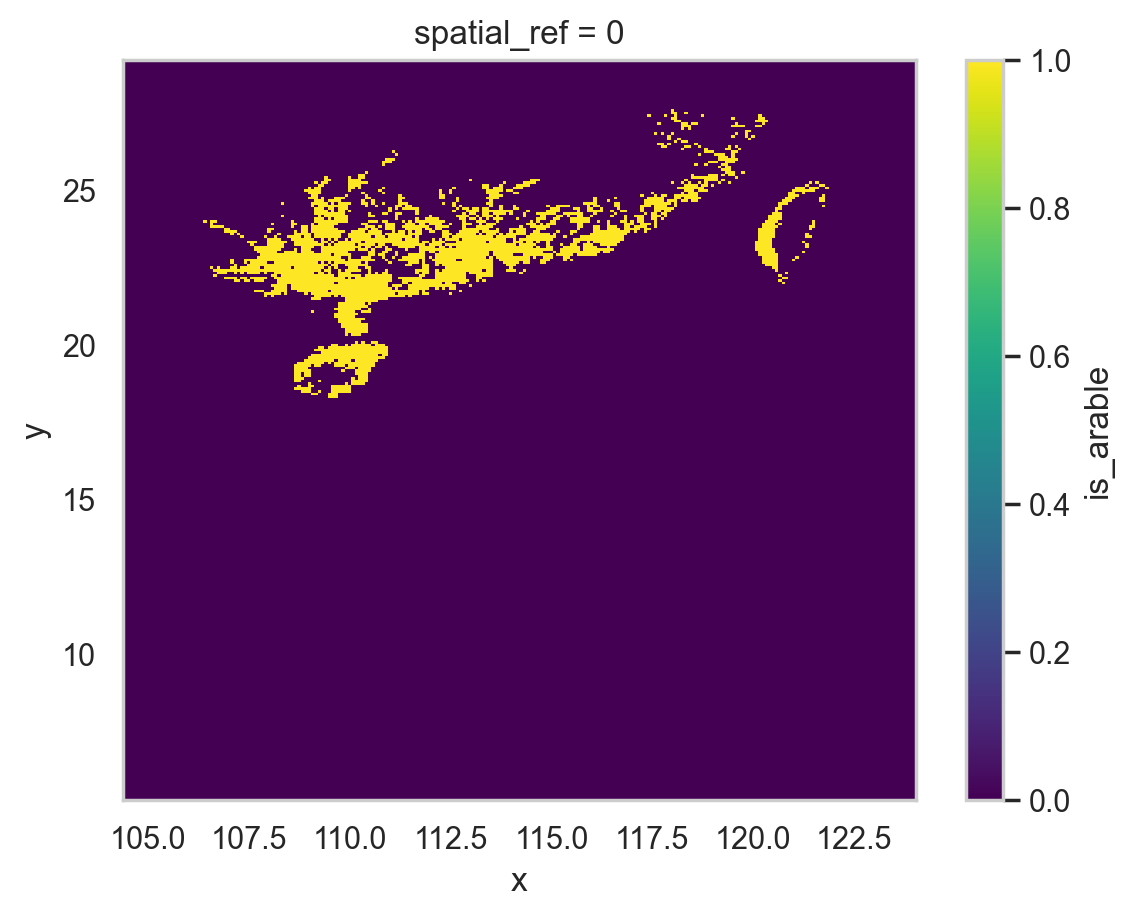

In [4]:
arable_land = model.nature.get_xarray("is_arable")
print(f"农民可以停留的可耕种土地有{arable_land.to_numpy().sum()}，分布如下图：")
arable_land.plot()

水稻农民可以停留的可耕种土地有924，分布如下图：


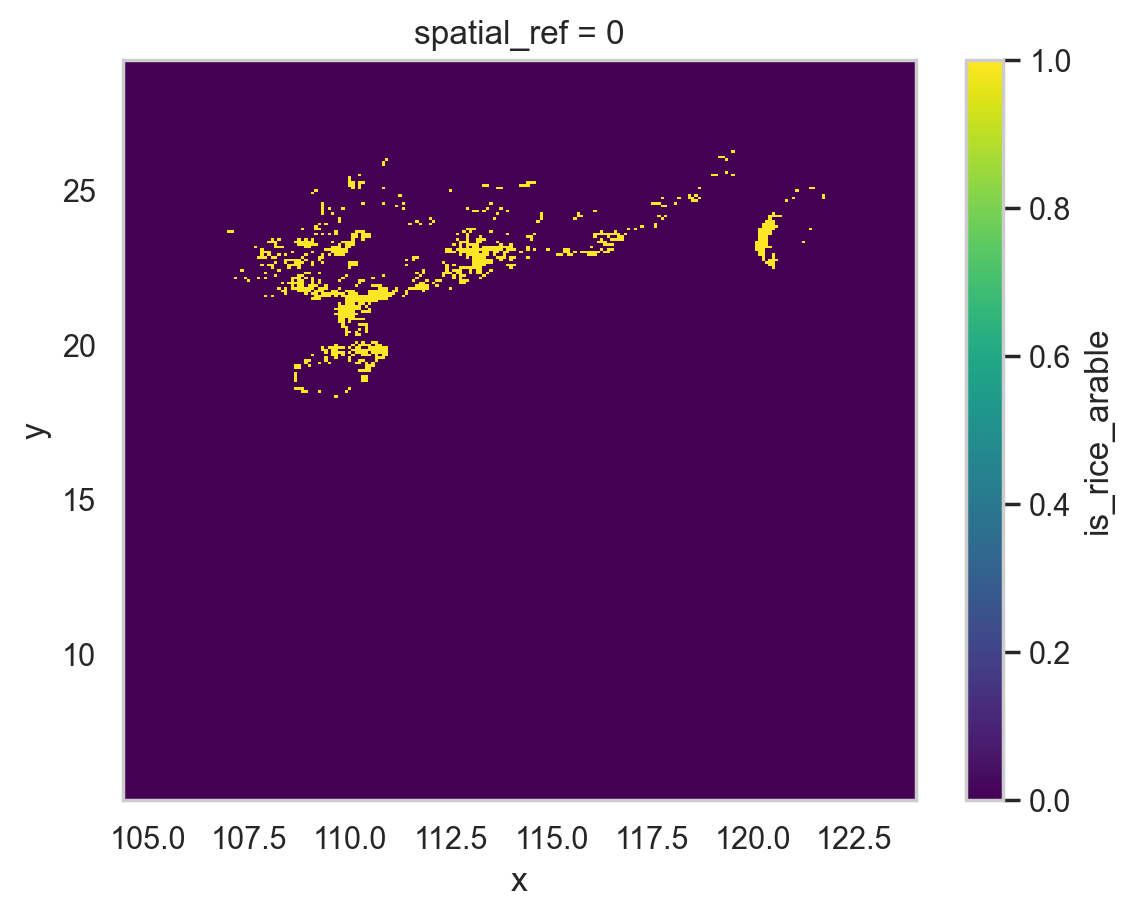

In [5]:
rice_arable = model.nature.patchmodule.get_xarray("is_rice_arable")
print(f"水稻农民可以停留的可耕种土地有{rice_arable.to_numpy().sum()}，分布如下图：")
rice_arable.plot()

增加了初始的 Hunters，随机生成在地图上

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

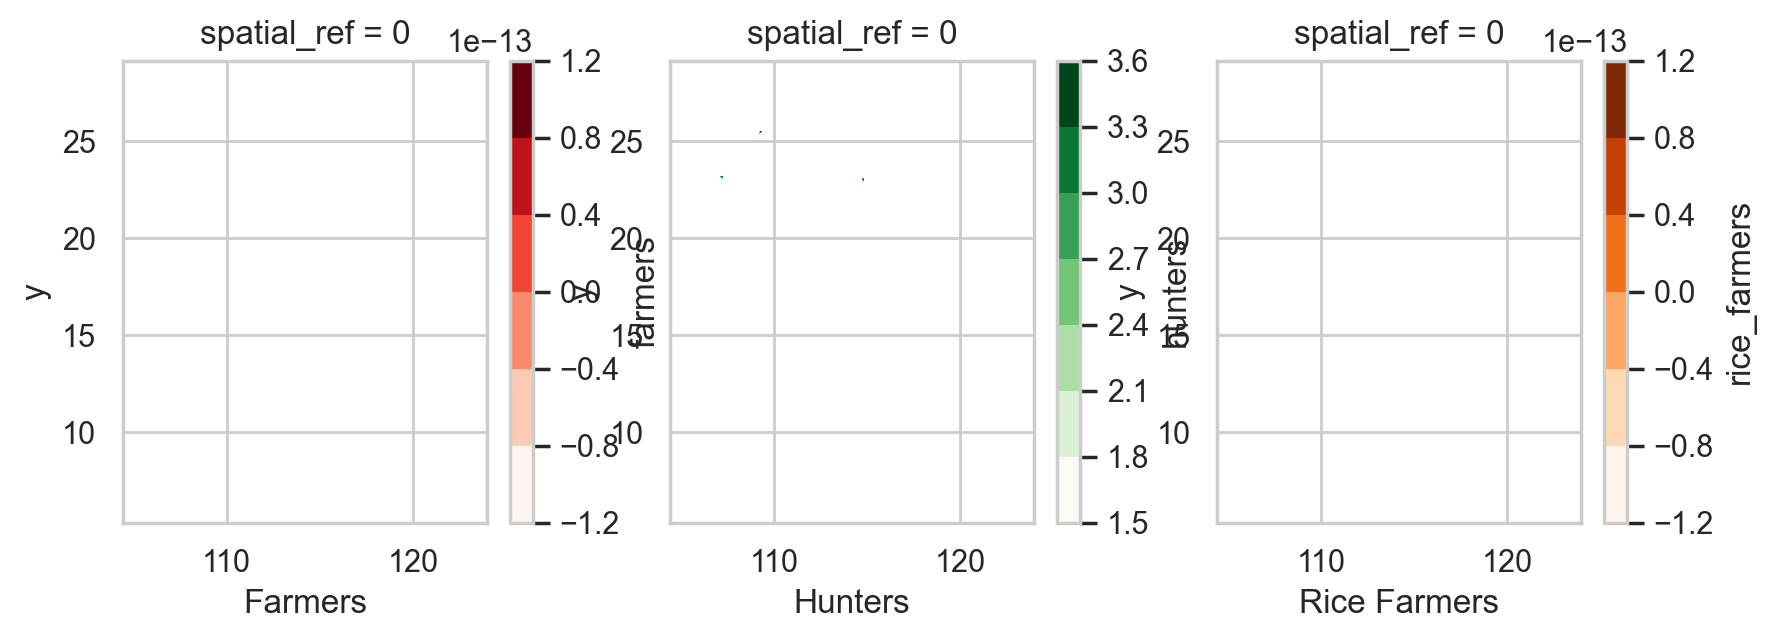

In [6]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

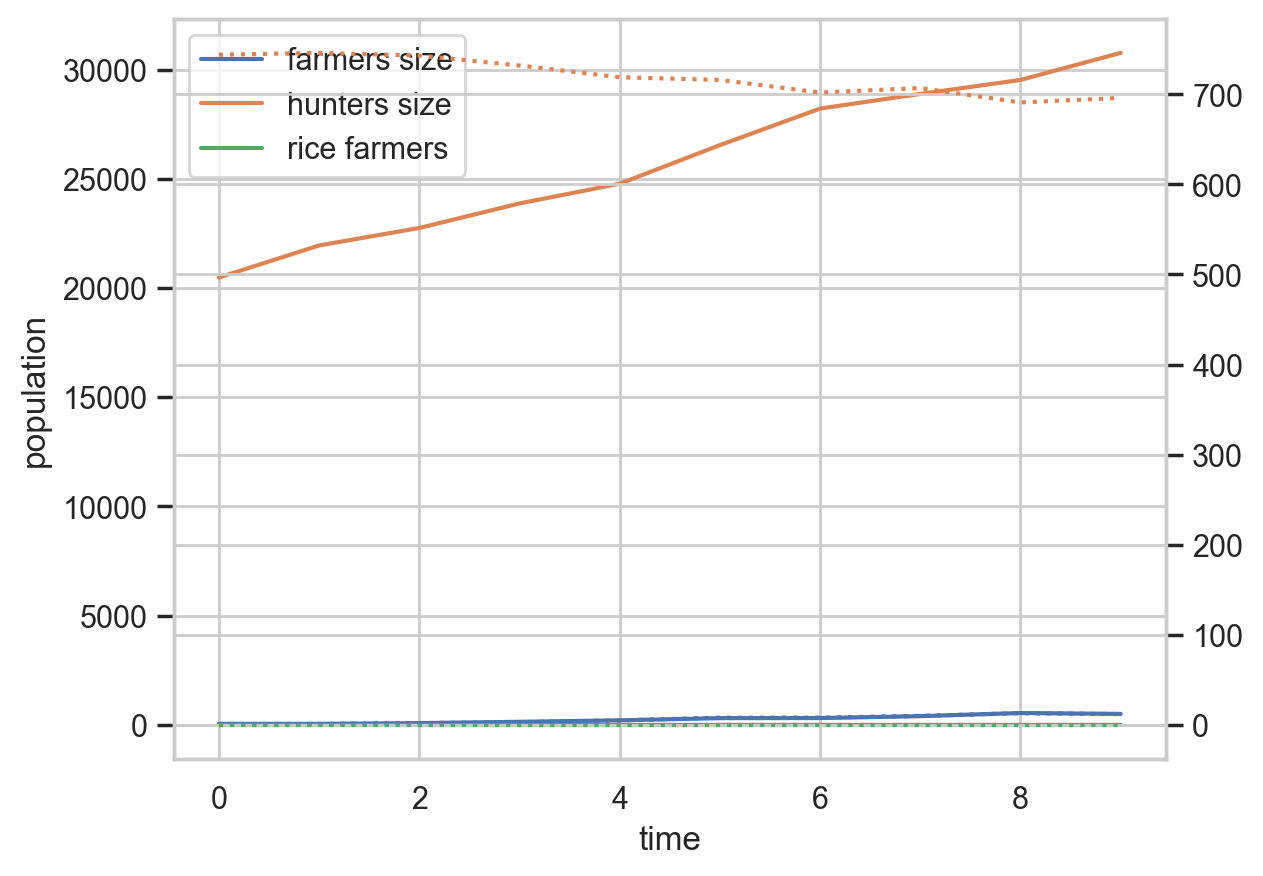

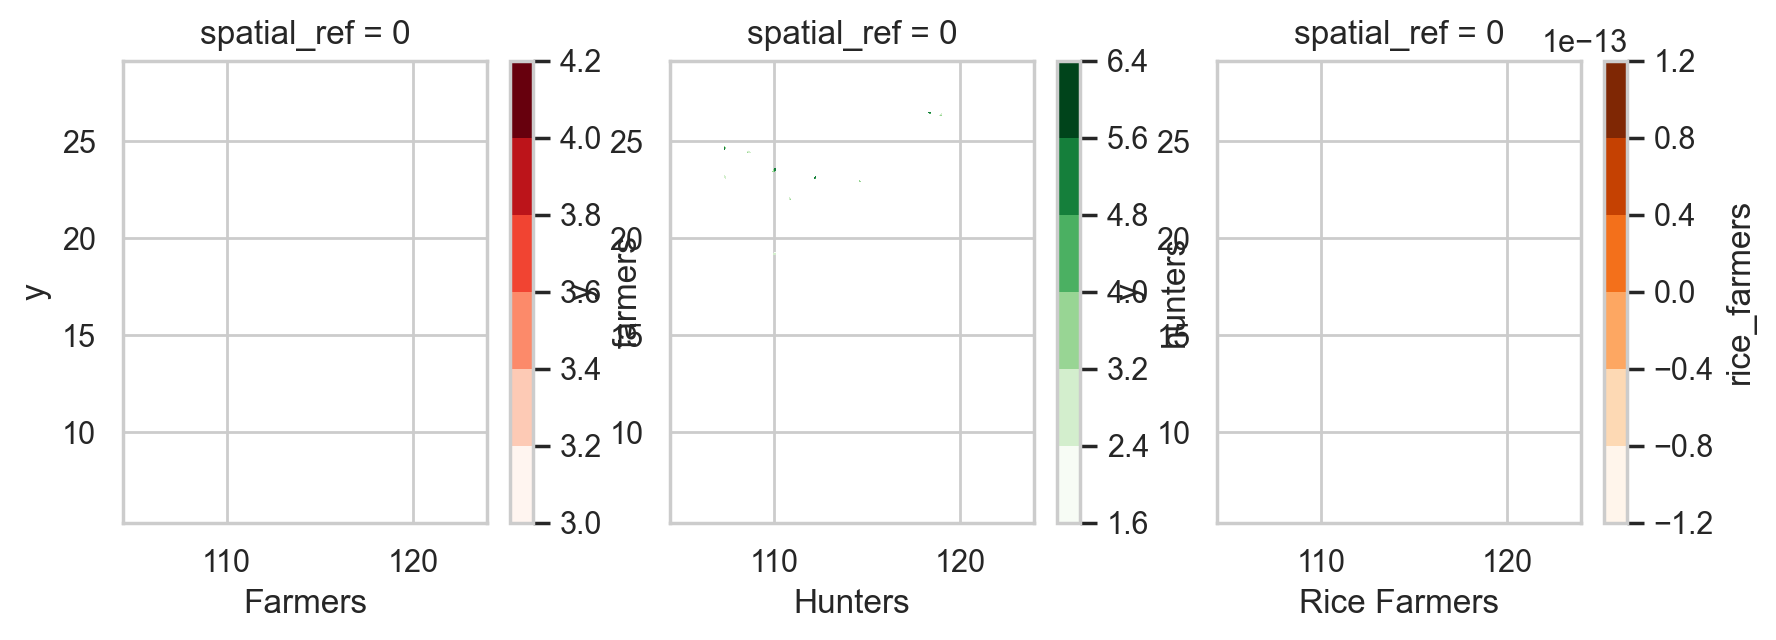

In [8]:
model.run_model(steps=200)

展示主体的信息

<Axes: xlabel='size', ylabel='Count'>

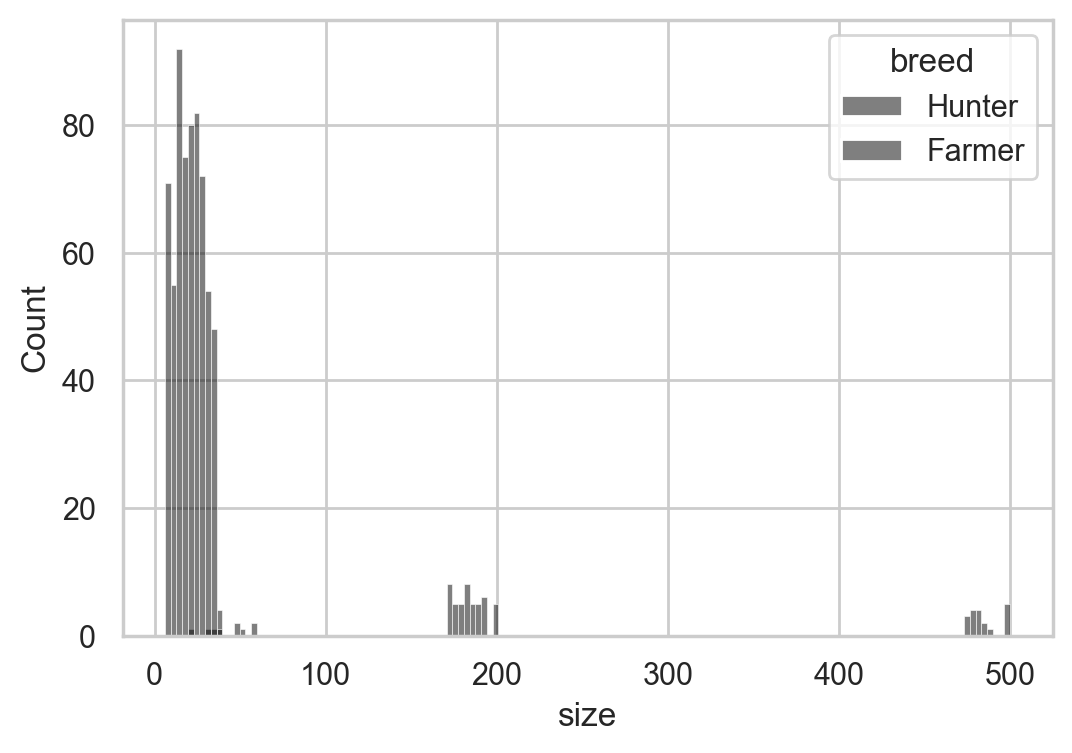

In [9]:
model.actors.plot.hist("size")

In [10]:
agent = model.actors.random.choice()
agent.report()

unique_id    Hunter[1383]
breed              Hunter
size                 25.0
position         (88, 84)
dtype: object

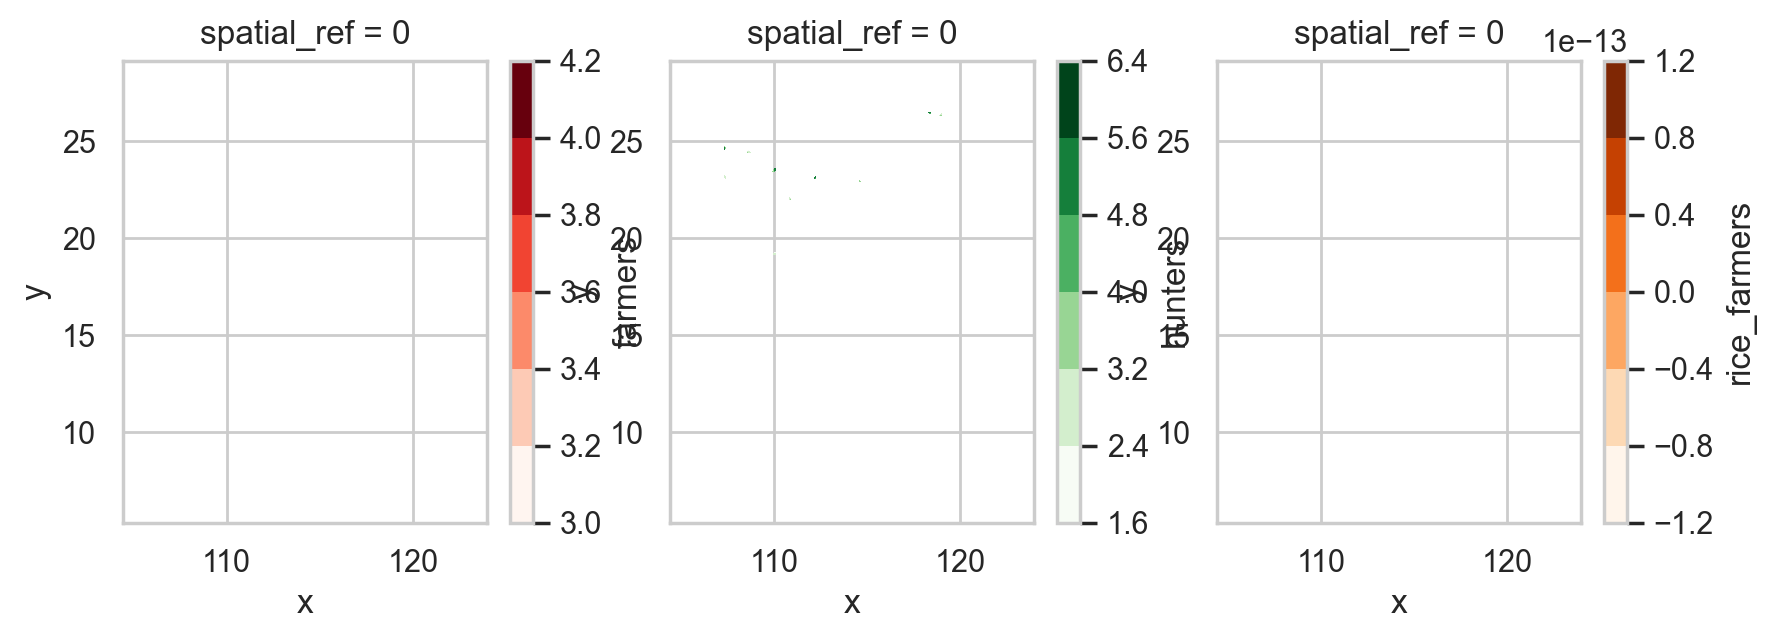

In [23]:
import xarray as xr


def log(xda_: xr.DataArray):
    return xr.apply_ufunc(np.log, xda_.where(xda_ != 0))


_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
mask = model.nature.get_xarray("elevation") >= 0
farmers = model.nature.get_xarray("farmers").where(mask)
hunters = model.nature.get_xarray("hunters").where(mask)
rice = model.nature.get_xarray("rice_farmers").where(mask)
# Calculate logarithmically, without warnings
log(farmers).plot.contourf(ax=ax1, cmap="Reds")
log(hunters).plot.contourf(ax=ax2, cmap="Greens")
log(rice).plot.contourf(ax=ax3, cmap="Oranges")

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

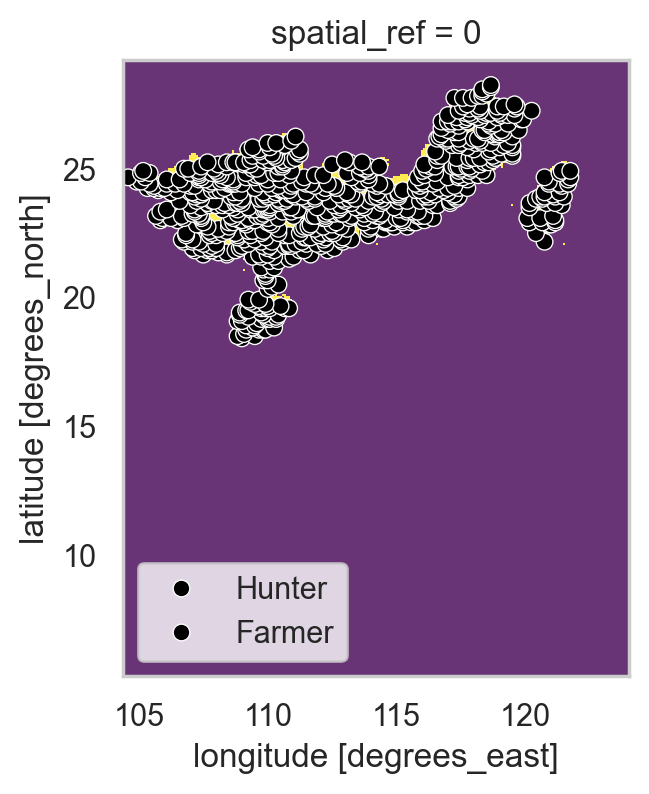

In [12]:
model.nature.plot.show()

(<Axes: xlabel='Population'>, <Axes: xlabel='Groups'>)

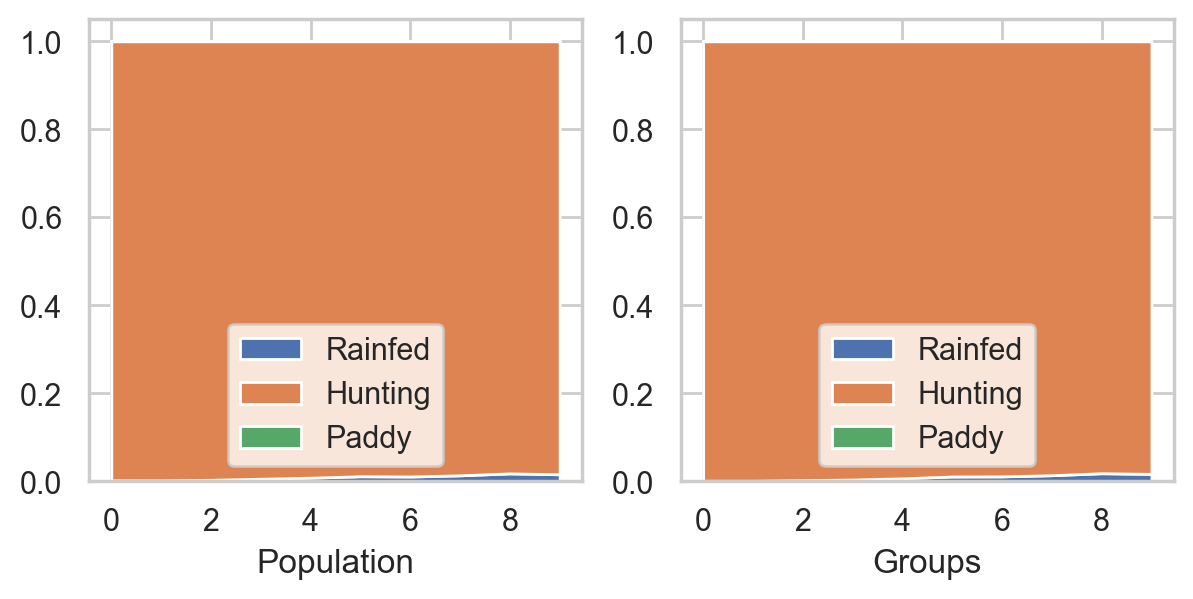

In [13]:
model.plot.stack_dynamic()

<Axes: xlabel='size', ylabel='Count'>

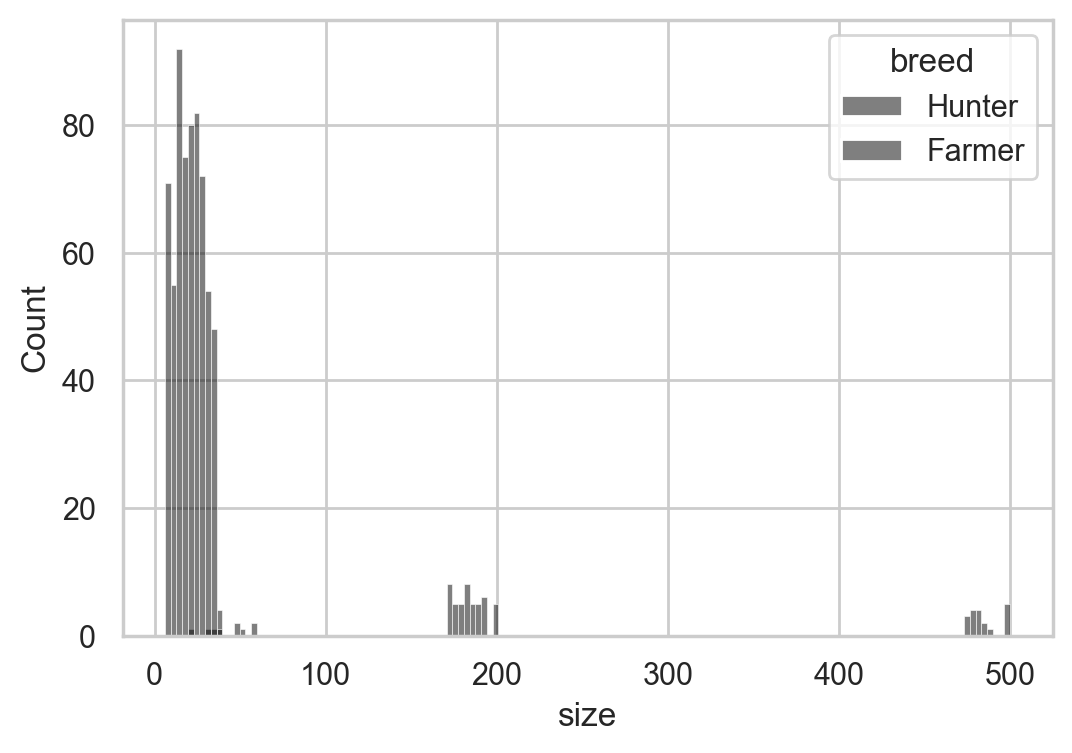

In [14]:
model.actors.plot.hist("size")

In [15]:
from src.core import MyExperiment

exp = MyExperiment(Model, nature_cls=Env)
exp.batch_run(
    cfg=cfg, repeats=10, parallels=5, overrides={"farmer.growth_rate": [0.1, 0.2, 0.3]}
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='tick', ylabel='num_farmers'>

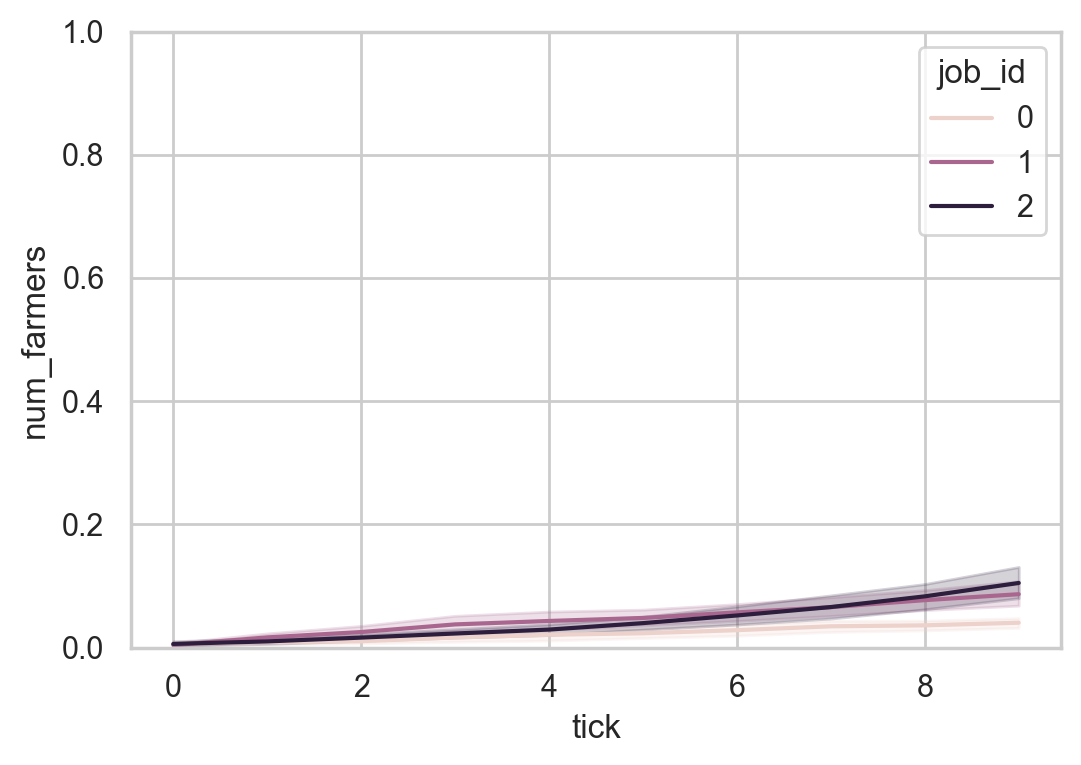

In [16]:
exp.plot_agg_dynamic("farmers", "num")

In [17]:
data = exp.get_model_vars_dataframe()
data.head()

,job_id,repeat_id,tick,len_farmers,len_hunters,len_rice,num_farmers,num_hunters,num_rice,len_farmers_n,len_hunters_n,len_rice_n,num_farmers_n,num_hunters_n,num_rice_n
0,0,1,0,0.002564,0.997436,0.0,0.004471,0.995529,0.0,1.0,389,0.0,38.0,8462.0,0.0
1,0,1,1,0.002564,0.997436,0.0,0.004866,0.995134,0.0,1.0,389,0.0,42.0,8589.0,0.0
2,0,1,2,0.002571,0.997429,0.0,0.005184,0.994816,0.0,1.0,388,0.0,47.0,9020.0,0.0
3,0,1,3,0.005181,0.994819,0.0,0.005122,0.994878,0.0,2.0,384,0.0,51.0,9906.0,0.0
4,0,1,4,0.005236,0.994764,0.0,0.005652,0.994348,0.0,2.0,380,0.0,57.0,10028.0,0.0


In [18]:
exp.summary()

,bkp_farmer,bkp_rice,bkp_hunters,pre_farmer,pre_rice,pre_hunters,post_farmer,post_rice,post_hunters,job_id,repeat_id,farmer.growth_rate
0,5,5,5,0.106766,NaN,0.043933,0.470634,NaN,0.057255,0,1,0.1
1,5,5,5,inf,NaN,0.051283,0.369990,NaN,0.042523,0,2,0.1
2,5,5,5,inf,NaN,0.037362,inf,NaN,0.064578,0,3,0.1
3,5,5,5,0.890766,NaN,0.055138,0.195507,NaN,0.059008,0,4,0.1
4,5,5,5,0.294578,NaN,0.040137,0.300827,NaN,0.047163,0,5,0.1
5,5,5,5,0.557075,NaN,0.033287,0.218086,NaN,0.067445,0,6,0.1
6,5,5,5,0.077373,NaN,0.028822,0.522004,NaN,0.042227,0,7,0.1
7,5,5,5,0.391355,NaN,0.020060,0.057696,NaN,0.041715,0,8,0.1
8,5,5,5,inf,NaN,0.057998,0.245743,NaN,0.041331,0,9,0.1
9,5,5,5,0.872935,NaN,0.017111,0.080447,NaN,0.046319,0,10,0.1


In [19]:
data.groupby(["job_id", "tick"])